In [1]:
# %matplotlib inline
%matplotlib widget
from hydrophone_data_processing import load, preprocessing, tempmatch
import obspy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.dates as mdates
import matplotlib.ticker as ticker

from obspy.signal.tf_misfit import cwt

class PrecisionDateFormatter(ticker.Formatter):
    """
    Extend the `matplotlib.ticker.Formatter` class to allow for millisecond
    precision when formatting a tick (in days since the epoch) with a
    `~datetime.datetime.strftime` format string.

    """

    def __init__(self, fmt, precision=3, tz=None):
        """
        Parameters
        ----------
        fmt : str
            `~datetime.datetime.strftime` format string.
        """
        from matplotlib.dates import num2date
        if tz is None:
            from matplotlib.dates import _get_rc_timezone
            tz = _get_rc_timezone()
        self.num2date = num2date
        self.fmt = fmt
        self.tz = tz
        self.precision = precision

    def __call__(self, x, pos=0):
        if x == 0:
            raise ValueError("DateFormatter found a value of x=0, which is "
                             "an illegal date; this usually occurs because "
                             "you have not informed the axis that it is "
                             "plotting dates, e.g., with ax.xaxis_date()")

        dt = self.num2date(x, self.tz)
        ms = dt.strftime("%f")[:self.precision]

        return dt.strftime(self.fmt).format(ms=ms)

    def set_tzinfo(self, tz):
        self.tz = tz
        
def minnaert_radius(freq, depth):
    # https://www.engineeringtoolbox.com/specific-heat-capacity-gases-d_159.html
    gamma = 1.405 # taken from website above for 300K
    rho = 997 # kg/m^3
    PA = (rho * 9.8 * depth) + 100000 # kg/(m*s^2)
    # PA/rho => PA(kg*m^-1*s^-2) / rho(kg * m^-3) =? PA(...) * rho(kg^-1 * m^3) => m^2 * s^-2
    return (2 * np.pi * freq)**(-1) * ((3 * gamma * PA)/(rho))**(1/2)

def ideal_gas_n(pressure, volume):
    P = pressure
    V = volume
    R = 8.31446261815324 # J K^−1 mol^−1
    T = 34.75 + 273.15 # K
    n = (P * V)/(R * T)
    return n

def get_mass(pressure, volume):
    n = ideal_gas_n(pressure, volume)
    avogadros_n = 6.0221409e23
    h2_mass = 1.6735575e-27
    return n * avogadros_n * h2_mass

# volume = lambda r: (4/3)*np.pi*r**3

def volume(r):
    return (4/3) * np.pi * r**3

# DATA IMPORT

## import bubble detections from matched filter

In [2]:
bubbles = load.import_bubble_detections('/media/sda/data/borehole/detections/*.csv')
bubbles.reset_index(inplace=True)

# calculate minnaert radius
bubbles['min_radius'] = minnaert_radius(freq=250, depth=15)
bubbles['max_radius'] = minnaert_radius(freq=200, depth=15)
bubbles['mean_radius'] = np.mean([minnaert_radius(freq=200, depth=15), minnaert_radius(freq=250, depth=15)])

# calculate volumes
bubbles['volume_min'] = bubbles.min_radius.apply(volume)
bubbles['volume_max'] = bubbles.max_radius.apply(volume)
bubbles['volume_mean'] = bubbles.mean_radius.apply(volume)

#  calculate mass
bubbles['mass_min'] = bubbles.volume_min.apply(lambda v: get_mass(pressure=(997 * 9.8 * 15) + 100000, volume=v))
bubbles['mass_max'] = bubbles.volume_max.apply(lambda v: get_mass(pressure=(997 * 9.8 * 15) + 100000, volume=v))
bubbles['mass_mean'] = bubbles.volume_mean.apply(lambda v: get_mass(pressure=(997 * 9.8 * 15) + 100000, volume=v))

In [58]:
bubsub = bubbles[bubbles.time.between('2019-05-18','2019-05-19')]

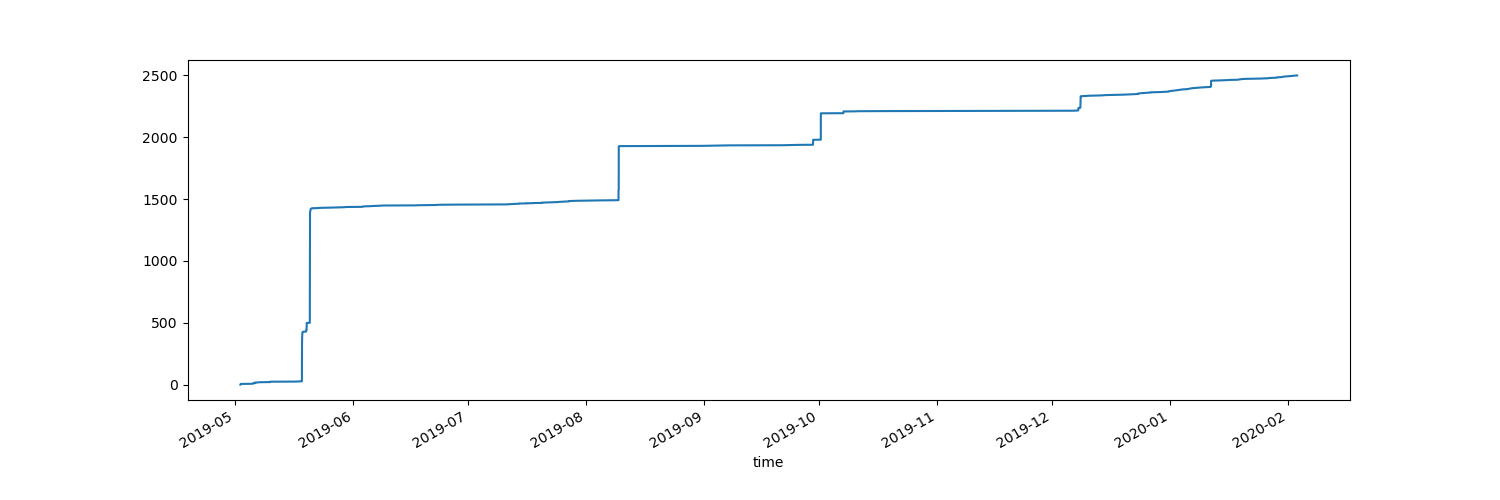

In [175]:
fig, ax = plt.subplots(figsize=(15, 5))
bubbles.set_index('time').ones.cumsum().plot(ax=ax)
# alpha = 
# nt = 400*(1- np.exp(-alpha*t))
event1 = bubbles[bubbles.time.between('2019-05-18 11:30:00', '2019-05-19 12:45:00')].copy()
event2 = bubbles[bubbles.time.between('2019-05-20 13:30:30', '2019-05-21 14:30:00')].copy()
event3 = bubbles[bubbles.time.between('2019-08-09 11:00:00','2019-08-09 12:15:00')].copy()
event4 = bubbles[bubbles.time.between('2019-08-09 13:00:00','2019-08-09 14:00:00')].copy()
event5 = bubbles[bubbles.time.between('2019-09-29 11:00:00','2019-09-29 11:30:00')].copy()
event6 = bubbles[bubbles.time.between('2019-10-01 12:00:00','2019-10-01 13:00:00')].copy()
event7 = bubbles[bubbles.time.between('2019-10-07 10:55:00','2019-10-07 11:05:00')].copy()
event8 = bubbles[bubbles.time.between('2019-12-08 00:00:00','2019-12-08 01:00:00')].copy()
event9 = bubbles[bubbles.time.between('2019-12-08 00:00:00','2019-12-08 01:00:00')].copy()
event10 = bubbles[bubbles.time.between('2019-12-08 12:50:00','2019-12-08 13:00:00')].copy()
event11 = bubbles[bubbles.time.between('2019-12-08 13:30:00','2019-12-08 15:30:00')].copy()

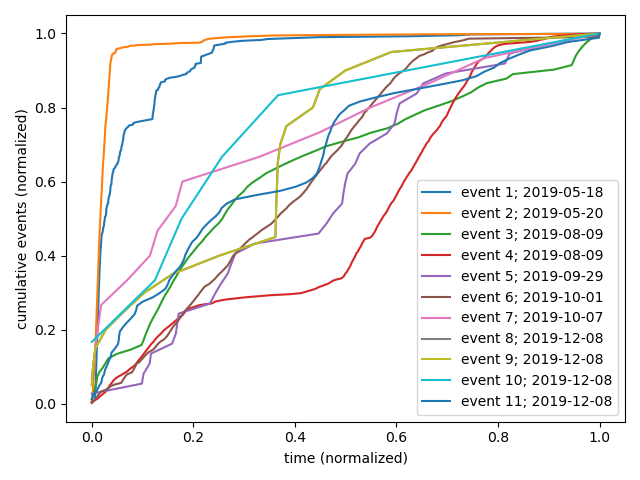

In [177]:
events = [event1, event2, event3, event4, event5, event6, event7, event8, event9, event10, event11]
fig, ax = plt.subplots()

for n, e in enumerate(events):
    y = e.ones.cumsum()
    y = y/y.max()
    time = e.time
    t = np.array([t.timestamp() for t in time])
    t = (t - t.min())
    t = t/t.max()
    ax.plot(t, y, label='event {n}; {t}'.format(n=n+1, t=time.min().date()))

ax.legend()
ax.set_ylabel('cumulative events (normalized)')
ax.set_xlabel('time (normalized)')

fig.tight_layout()

datetime.date(2019, 12, 8)

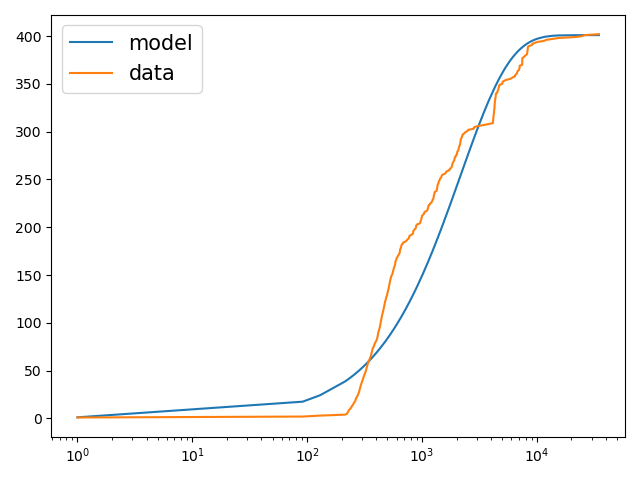

In [145]:
y = bubsub.set_index('time').ones.cumsum().values
time = bubsub.set_index('time').ones.cumsum().index

t = np.array([t.timestamp() for t in time])
t = t - t.min()
t = t + 1
alpha = 1/(t[-1] - t[0])
alpha = 5/10800
nt =1 + 400*(1 - np.exp(-alpha*t))

fig, ax = plt.subplots()
ax.plot(t, nt, label='model')
ax.plot(t, y, label='data')
ax.legend(fontsize=15)
ax.set_xscale('log')
# ax.set_xlim(1e0, 4e4)
fig.tight_layout()

array([  1.00000185,  17.39117874,  24.10264753,  38.57609231,
        39.99431391,  40.30020343,  40.89953536,  41.13069233,
        41.54829807,  42.33955095,  42.98571931,  43.32881759,
        43.79993751,  44.46130219,  44.99241299,  45.22160148,
        45.81933359,  46.46070997,  46.70437195,  46.94409649,
        47.22690035,  47.79837148,  48.29659002,  48.71958027,
        49.01921732,  49.35099828,  49.74686879,  50.06480405,
        50.2507829 ,  50.46895899,  50.69932493,  50.91041478,
        51.12980033,  51.45797358,  51.68202938,  51.97769241,
        52.34865449,  52.78193945,  53.04139416,  53.23287979,
        53.55200283,  53.96451311,  54.23994348,  54.59246411,
        54.86659489,  55.30395275,  55.66690298,  55.86317543,
        56.41447423,  56.70039344,  56.97492663,  57.16902302,
        57.37748691,  57.76368599,  57.9981507 ,  58.28846775,
        58.60754854,  58.82052649,  59.23833214,  59.58166169,
        60.10997674,  60.6699332 ,  60.98868574,  61.36

In [102]:
t.shape

(402,)

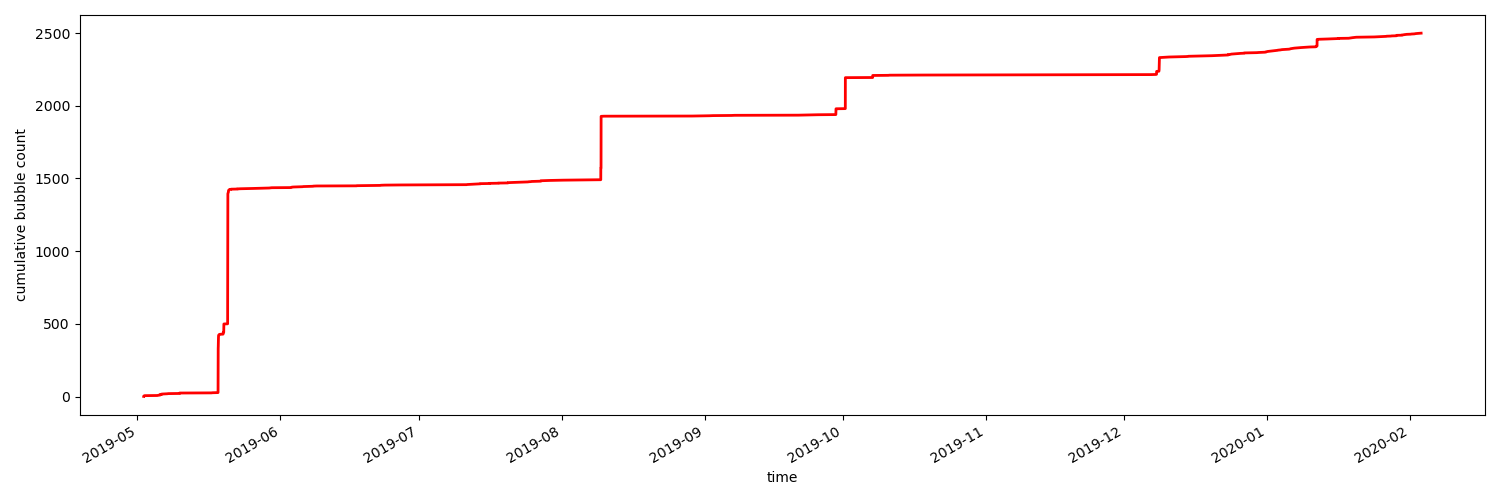

In [19]:
fig, ax = plt.subplots(figsize=(15, 5))
bubbles.set_index('time').cumsum().ones.plot(ax=ax, color='red', linewidth=2)
ax.set_ylabel('cumulative bubble count')
fig.tight_layout()

In [4]:
bubbles.time[1] - bubbles.time[0]

Timedelta('0 days 00:00:50.954000')

In [5]:
np.arange(0, bubbles.shape[0], 1)

array([   0,    1,    2, ..., 2496, 2497, 2498])

In [6]:
(6777/60)/60

1.8825

In [7]:
dts = []
deltaT = [0,]
for n in np.arange(0, bubbles.shape[0], 1):
    if n+1 == bubbles.shape[0]:
        break
        
    dt = bubbles.time[n+1] - bubbles.time[n]
    dts.append(dt)
    # deltaT.append(dt.seconds)
    deltaT.append(dt.seconds+dt.microseconds*1e-6)
    
bubbles['TimeDelta'] = dt
bubbles['deltaT_sec'] = deltaT

In [8]:
bubbles.deltaT_sec.hist(log=True, bins=100)

<AxesSubplot:xlabel='time'>

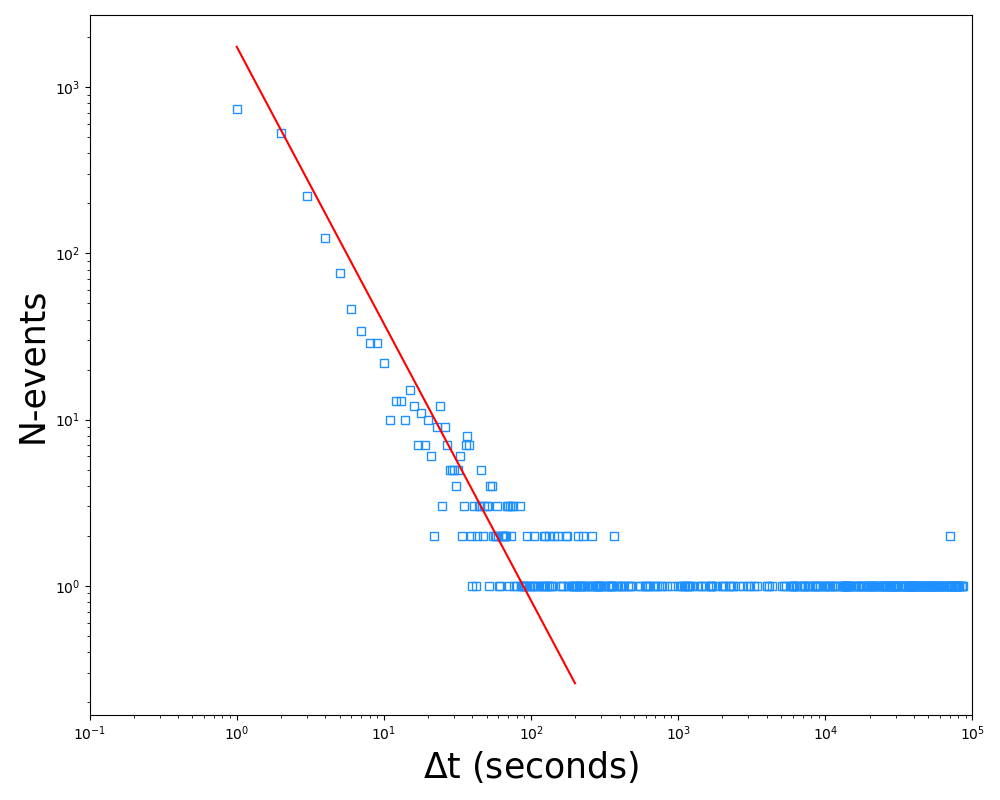

In [54]:
h, e = np.histogram(bubbles.deltaT_sec[1:], bins=np.linspace(0, 100000, 100000) )
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(e[:-1], h, color='dodgerblue', linewidth=0, marker='s', fillstyle='none')
# ax.set_xscale('log')
ax.set_xlim(1e-1, 1e5)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel('N-events', fontsize=25)
ax.set_xlabel('$\Delta$t (seconds)', fontsize=25)

x = np.arange(1e0, 2e2)
y = 1750*x**(-1.666) # satan number
ax.plot(x, y, color='red')

# ax.plot(h[h<0], color='red', marker='s')

fig.tight_layout()

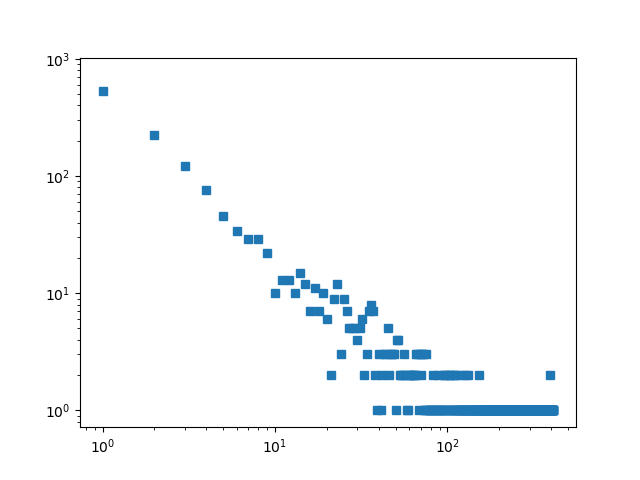

In [50]:
fig, ax = plt.subplots()
ax.plot( h[h>0], marker='s', linewidth=0)
ax.set_yscale('log')
ax.set_xscale('log')

In [10]:
bubbles.deltaT_sec[1:].min()

1.103

In [11]:
bubbles.deltaT_sec[1:].max()

86145.286

In [12]:
e

array([0.00000e+00, 1.00001e+00, 2.00002e+00, ..., 9.99980e+04,
       9.99990e+04, 1.00000e+05])

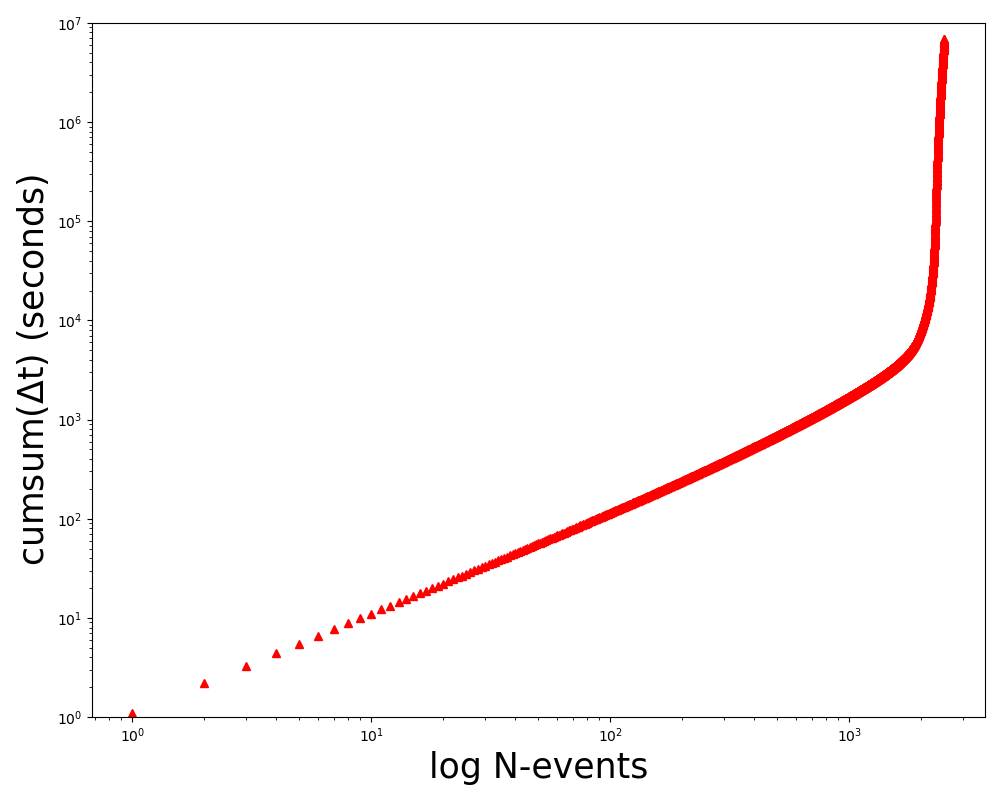

In [21]:
x = bubbles.deltaT_sec[1:].sort_values()
y = x.cumsum()

fig, ax = plt.subplots(figsize=(10, 8))
# ax.plot(x, y, color='red')
ax.plot(np.arange(1, x.shape[0]+1, 1), y, color='red', marker='^', linewidth=0)
# ax.plot([0, 1e5], [0, 1e5])
ax.set_ylim(1e0, 1e7)
# ax.set_xlim(1e-1, 1e5)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel('cumsum($\Delta$t) (seconds)', fontsize=25)
ax.set_xlabel('log N-events', fontsize=25)
fig.tight_layout()

In [14]:
bubbles.deltaT_sec[1:].sort_values().max()

86145.286

In [15]:
x

828         1.103000
927         1.105000
2412        1.105000
162         1.105000
682         1.105000
            ...     
1471    81387.781000
1932    84342.382999
1472    84685.098000
1432    85224.280000
1456    86145.286000
Name: deltaT_sec, Length: 2498, dtype: float64

## import day 138 degassing raw data

In [3]:
paths = ['/media/sda/data/robdata/Hydrophones/DAYS/B00/B00.7F.01.GDH.2019.{julian_day}'
        ,'/media/sda/data/robdata/Hydrophones/DAYS/B00/B00.7F.02.GDH.2019.{julian_day}'
        ,'/media/sda/data/robdata/Hydrophones/DAYS/B00/B00.7F.03.GDH.2019.{julian_day}'
        ,'/media/sda/data/robdata/Hydrophones/DAYS/B00/B00.7F.04.GDH.2019.{julian_day}'
        ,'/media/sda/data/robdata/Hydrophones/DAYS/B00/B00.7F.05.GDH.2019.{julian_day}'
        ,'/media/sda/data/robdata/Hydrophones/DAYS/B00/B00.7F.06.GDH.2019.{julian_day}']

In [4]:
day138paths = [p.format(julian_day=138) for p in paths]
day138 = load.import_corrected_data_for_single_day(paths=day138paths)

In [5]:
day140paths = [p.format(julian_day=140) for p in paths]
day140 = load.import_corrected_data_for_single_day(paths=day140paths)

# FIGURE 2 BUBBLE COUNT CURVE

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
bubbles.set_index('time').cumsum().ones.plot(ax=ax, color='red', linewidth=2)

# FIGURE 2 MASS FLUX

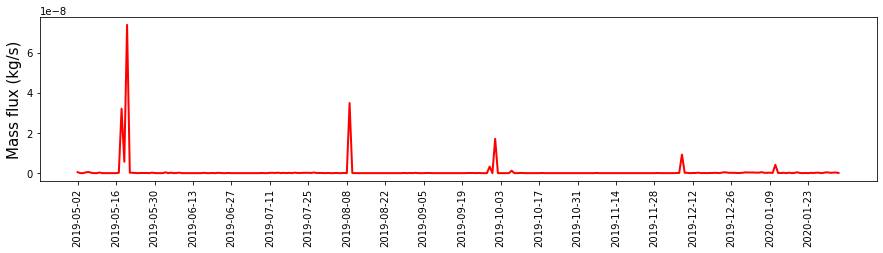

In [6]:
fig, ax = plt.subplots(figsize=(15, 3))
max_mass = bubbles.reset_index().groupby(pd.Grouper(key='time', freq='D')).sum().mass_max
max_mass = max_mass/86400 # convert to kg/s
x = max_mass.index
y = max_mass.values

ax.plot(x, y, color='red', linewidth=2)
ax.set_ylabel('Mass flux (kg/s)', fontsize=15)
ax.set_xticks(x[::14])
ax.set_xticklabels([str(d).split(' ')[0] for d in x[::14]], rotation=90)
fig.savefig('figures/fig2bottom.pdf', bbox_inches='tight')

# FIGURE 3

In [7]:
# detectfiles = '/media/sda/data/borehole/detections/*.csv'
# det = load.import_detections(detectfiles)

In [8]:
# det = det[det.similarity>0.95]
# det.shape

In [9]:
# paths = ['/media/sda/data/robdata/Hydrophones/DAYS/B00/B00.7F.01.GDH.2019.138'
#         ,'/media/sda/data/robdata/Hydrophones/DAYS/B00/B00.7F.02.GDH.2019.138'
#         ,'/media/sda/data/robdata/Hydrophones/DAYS/B00/B00.7F.03.GDH.2019.138'
#         ,'/media/sda/data/robdata/Hydrophones/DAYS/B00/B00.7F.04.GDH.2019.138'
#         ,'/media/sda/data/robdata/Hydrophones/DAYS/B00/B00.7F.05.GDH.2019.138'
#         ,'/media/sda/data/robdata/Hydrophones/DAYS/B00/B00.7F.06.GDH.2019.138']

In [10]:
# day138 = load.import_corrected_data_for_single_day(paths=paths)

In [11]:
starttime = obspy.UTCDateTime('2019-05-18T14:30:00')
endtime = obspy.UTCDateTime('2019-05-18T14:40:00')
tempraw = day138.copy().trim(starttime=starttime, endtime=endtime)
# tempraw = tempmatch.digest_data(tempraw)
# temp = tempmatch.make_template(hole='B')
temp = tempmatch.make_template(hole='B', raw=True)

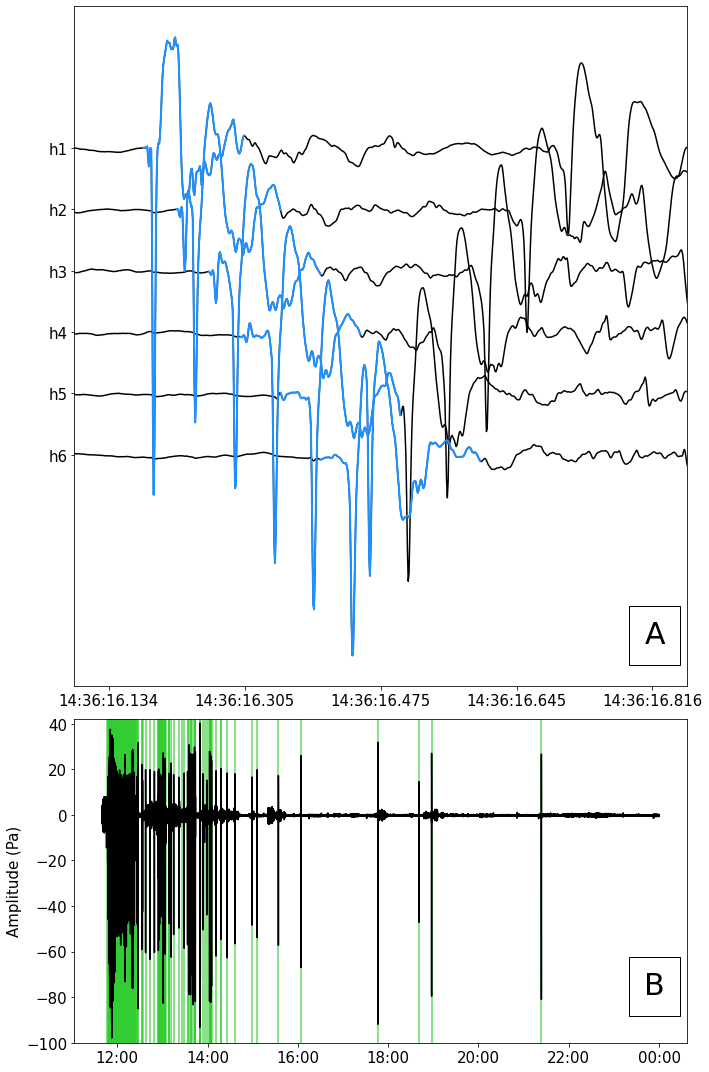

In [12]:
###############
#   template  #
###############
fig = plt.figure(figsize=(10, 15))
ax1 = plt.subplot2grid((3,2), (0, 0), colspan=2, rowspan=2)
ax2 = plt.subplot2grid((3,2), (2, 0), colspan=3, )

ax = (ax1, ax2)

for n, tr in enumerate(tempraw):
    ax[0].plot(tr.times('matplotlib'), tr.data-10*n, color='black')
    
for n, tr in enumerate(temp):
    ax[0].plot(tr.times('matplotlib'), tr.data-10*n, color='dodgerblue', linewidth=2)
    
yticks = np.array([0, 10, 20, 30, 40, 50])*-1
ax[0].set_yticks(yticks)
ylabels = ['h1', 'h2', 'h3', 'h4', 'h5', 'h6']
ax[0].set_yticklabels(ylabels, fontsize=15)
# ax[0].set_xticklabels(fontsize=15)
    
ax[0].set_xlim(temp[0].times('matplotlib').min()-1e-6, temp[-1].times('matplotlib').max()+3e-6)

xticks = np.linspace(temp[0].times('matplotlib').min()-0.5e-6, temp[-1].times('matplotlib').max()+2.5e-6, 5)
ax[0].set_xticks(xticks)
ax[0].set_xticklabels(xticks, fontsize=15)
ax[0].xaxis.set_major_formatter(PrecisionDateFormatter('%H:%M:%S.{ms}'))

###################
#   all day 138   #
###################
# data = det[det.time.between('2019-05-18', '2019-05-19')].copy()
data = bubbles[bubbles.time.between('2019-05-18', '2019-05-19')].copy()

x = data.time
y = np.ones_like(x)*500
ax[1].plot([x, x], [-y, y], color='limegreen', alpha=0.75)

h1 = day138[0].slice(starttime=obspy.UTCDateTime('2019-05-18T11:40:00'))
ax[1].plot(h1.times('matplotlib'), h1.data, color='black')

ax[1].set_ylim(-100, 42)
ax[1].set_ylabel('Amplitude (Pa)', fontsize=15)
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax[1].tick_params(axis='x', labelsize=15)
ax[1].tick_params(axis='y', labelsize=15)

bbox = dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.5')
# ax[1].text(s='March 18, 2019', fontsize=20, x=h1.times('matplotlib').min(), y=-90, bbox=bbox)

bbox = dict(facecolor='none', edgecolor='black', boxstyle='square,pad=0.5')
# ax[0].text(s='A', fontsize=20, x=temp[-1].times('matplotlib').max()+2.25e-6, y=-70, bbox=bbox)
fig.text(s='A', fontsize=30, x=0.9, y=0.4, bbox=bbox)
fig.text(s='B', fontsize=30, x=0.9, y=0.075, bbox=bbox)

fig.tight_layout()
# fig.savefig('figures/bubbles_time_series_day138_AND_bubble_templates_with_reflections.pdf', bbox_inches='tight')

# FIGURE 4 CWT FREQUENCY

In [13]:
bubbles.iloc[1354]

time           2019-05-20 14:17:26.435000+00:00
similarity                             0.993082
template_id                                   0
ones                                          1
min_radius                             0.020554
max_radius                             0.025692
mean_radius                            0.023123
volume_min                             0.000036
volume_max                             0.000071
volume_mean                            0.000052
mass_min                               0.000004
mass_max                               0.000007
mass_mean                              0.000005
Name: 1354, dtype: object

In [14]:
# fig, (ax, ax2) = plt.subplots(2, 1, figsize=(15, 7))

# ax.plot(day138[0].times('matplotlib'), day138[0].data)
# ax2.plot(day140[0].times('matplotlib'), day140[0].data)

In [15]:
# temp

In [16]:
# fig, (ax, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# data = day138.slice(starttime=obspy.UTCDateTime('2019-05-18T14:36:16')
#                     ,endtime=obspy.UTCDateTime('2019-05-18T14:36:16')+0.5)
# ax.plot(data[0].times(), data[0].data)

# ax.plot(temp[0].times(), temp[0].data, color='red')

# data = day140.slice(starttime=obspy.UTCDateTime(bubbles.iloc[1354].time)-0.5
#                    ,endtime=obspy.UTCDateTime(bubbles.iloc[1354].time)+0.5)
# ax2.plot(data[0].times(), data[0].data)

In [17]:
# data.plot()

/tmp/ipykernel_1013/2572599256.py:79: UserWarning: Use the colorbar set_ticks() method instead.
  cbar_ax.set_yticks(np.arange(-25, 5, 5))
/tmp/ipykernel_1013/2572599256.py:80: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar_ax.set_yticklabels(np.arange(-25, 5, 5), fontsize=15)
/tmp/ipykernel_1013/2572599256.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


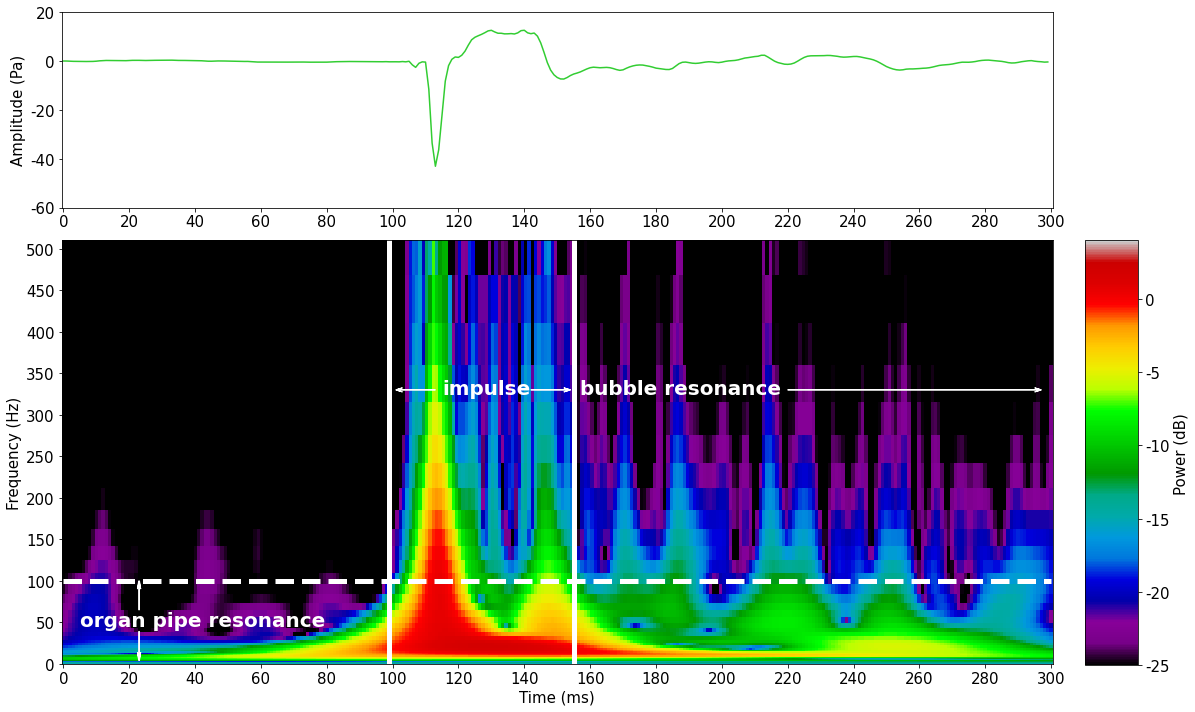

In [92]:
fig = plt.figure(figsize=(15, 10))
ax = plt.subplot2grid((3, 3), (0, 0), colspan=3)
ax2 = plt.subplot2grid((3, 3), (1, 0), colspan=3, rowspan=2, sharex=ax)

f_min = 0.001
f_max = 500
dt = day138[0].stats.delta

# f_min = 0.001
# f_max = 500
# dt = day138[0].stats.delta

i = 1354

# bw_h1 = bubbles[i].values
bw_h1 = day140.slice(starttime=obspy.UTCDateTime(bubbles.iloc[1354].time)-0.5
                   ,endtime=obspy.UTCDateTime(bubbles.iloc[1354].time)+0.5)[0].data
bw_h1 = bw_h1[400:700]
npts = bw_h1.shape[0]

t = np.linspace(0, dt*npts, npts)
scalogram = cwt(bw_h1, dt, 3, f_min, f_max)

x, y = np.meshgrid(t, np.logspace(np.log10(f_min), np.log10(f_max), scalogram.shape[0]))

ax.plot(bw_h1, color='limegreen')
ax.set_ylabel('Amplitude (Pa)', fontsize=15)

# ax.set_xticks([])

cbar = ax2.pcolormesh(x*1000, y, 10*np.log10(np.abs(scalogram))
                      , cmap='nipy_spectral', shading='auto'
                      , vmax=4, vmin=-25)

# add_axes([xmin,ymin,dx,dy])
cbar_ax = fig.add_axes([1.008, 0.07, 0.049, 0.59])
c = fig.colorbar(cbar, cax=cbar_ax)

c.ax.set_ylabel('Power (dB)', fontsize=15)


ax2.set_ylabel('Frequency (Hz)', fontsize=15)
ax2.set_xlabel('Time (ms)', fontsize=15)

ax2.set_ylim(0, 510)

ax2.plot([0, 300], [100, 100], linestyle='--', linewidth=5, color='white')
ax2.plot([99, 99], [0, 550], linestyle='-', linewidth=5, color='white')
ax2.plot([155, 155], [0, 550], linestyle='-', linewidth=5, color='white')

ax2.text(s='organ pipe resonance', x=5, y=45, color='white', fontsize=20, weight='bold')
ax2.arrow(x=23, y=65, dx=0, dy=25, color='white', width=0.25, overhang=1, head_width= 1, head_length=10)
ax2.arrow(x=23, y=39, dx=0, dy=-25, color='white', width=0.25, overhang=1, head_width=1, head_length=10)

ax2.text(s='impulse', x=115, y=325, color='white', fontsize=20, weight='bold')
ax2.arrow(x=68+45, y=330, dx=-10, dy=0, color='white', width=0.25, overhang=1, head_width=5 , head_length=2)
ax2.arrow(x=85+57, y=330, dx=10, dy=0, color='white', width=0.25, overhang=1, head_width=5 , head_length=2)

ax2.text(s='bubble resonance', x=157, y=325, color='white', fontsize=20, weight='bold')
ax2.arrow(x=220, y=330, dx=75, dy=0, color='white', width=0.25, overhang=1, head_width=5 , head_length=2)

# ax3 = fig.add_axes([0.6, 0.6, 0.35, 0.175]), head_length=2
# ax3.hist((10*np.log10(np.abs(scalogram))).flatten(), bins=40*3)
# ax3.set_xlabel('Power (dB)', fontsize=15)

x = np.arange(0, 310, 20)
ax.set_xticks(x)
ax.set_xticklabels(x, fontsize=15)

ax2.set_xticks(x)
ax2.set_xticklabels(x, fontsize=15)

ax.set_yticks(np.arange(-60, 30, 20))
ax.set_yticklabels(np.arange(-60, 30, 20), fontsize=15)

ax2.set_yticks(np.arange(0, 510, 50))
ax2.set_yticklabels(np.arange(0, 510, 50), fontsize=15)

cbar_ax.set_yticks(np.arange(-25, 5, 5))
cbar_ax.set_yticklabels(np.arange(-25, 5, 5), fontsize=15)

fig.tight_layout()

fig.savefig('figures/cwt_supp.pdf', bbox_inches='tight')
# plt.close()

In [59]:
115-70

45